<a href="https://colab.research.google.com/github/BaduA/malaria-diagnosis-ai/blob/main/MalariaDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
dataset, dataset_info = tfds.load("malaria",with_info=True,as_supervised=True,shuffle_files=True,split=["train"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete81E8P3/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    length = len(dataset)
    train_data = dataset.take(int(TRAIN_RATIO*length))
    val_test_data = dataset.skip(int(TRAIN_RATIO*length))
    val_data = val_test_data.take(int(VAL_RATIO*length))
    test_data = val_test_data.skip(int(VAL_RATIO*length))
    return train_data, val_data, test_data

In [4]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

train_data, val_data, test_data = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)


# **Visualization**

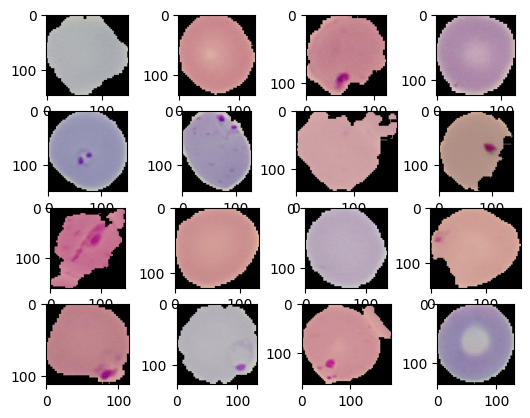

In [5]:
for i, (image,label) in enumerate(train_data.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)


## **Data Preprocessing**

In [6]:
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255, label

In [7]:
train_data = train_data.map(resize_rescale)
val_data = train_data.map(resize_rescale)
test_data = train_data.map(resize_rescale)

In [8]:
train_data = train_data.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [9]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [10]:
IM_SIZE = 224
model = tf.keras.Sequential(
    [InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

     Conv2D(filters=6,kernel_size=3,strides=1,padding="valid",activation="relu"),
     BatchNormalization(),
     MaxPool2D(pool_size=2,strides=2),

     Conv2D(filters=16,kernel_size=3,strides=1,padding="valid",activation="relu"),
     BatchNormalization(),

     MaxPool2D(pool_size=2,strides=2),
     Flatten(),

     Dense(100, activation="relu"),
     BatchNormalization(),

     Dense(10, activation="relu"),
     BatchNormalization(),

     Dense(1, activation="sigmoid"),

])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [11]:
model.compile(
    optimizer = Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics="accuracy")


In [ ]:
history = model.fit(train_data,epochs=100,verbose=1)

Epoch 1/100
103/517 [====>.........................] - ETA: 11:39 - loss: 0.6588 - accuracy: 0.6186